<a href="https://colab.research.google.com/github/GokulGS/CloudComputing/blob/main/220579243.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Performance evaluation of Terapixel rendering in Cloud (Super)computing**

# **Introduction**
The Objective in this report is to investigate aspect of the Performace evaluation of Terapixel rendering in cloud computing. The issue we aimed to address in this study was how to provide the supercomputer scale resources required to build a realistic terapixel picture of Newcastle upon Tyne and its environmental data as recorded by the Newcastle Urban Observatory. The three key objectives of this work are to: create a supercomputer architecture for scalable visualization using the public cloud; produce a terapixel 3D city visualization supporting daily updates; undertake a rigorous evaluation of cloud supercomputing for compute intensive visualization applications.  


# **Methodology**
The EDA process is the sole subject of this study, which is described in terms of a hierarchical process model. This model is made up of sets of tasks that are detailed at various levels. In order to design a data mining project, this provides a systematic strategy.

## Business Understanding
Identifying the requirements and objectives of the project from a commercial perspective is the main purpose of this initial stage. It is therefore possible to identify the data mining challenge and develop a basic plan of attack to reach the objectives using this understanding.



## Data Understanding
The preparation of the data is an essential part in exploratory data analysis. It describes the procedure for locating and importing data into our system. Good, trustworthy data may be purchased from private groups or acquired on a variety of public websites. The dataset below was produced using inputs from system metrics and application checkpoints during the creation of a terapixel picture. The TeraScope dataset may be used to solve a number of different issues. For this analysis, there are 3 data file has been used and for easy connection the files are stored in the google drive and connected and called using the below set of code.
```
data1=pd.read_csv('/content/gdrive/MyDrive/Cloud_computing/application-checkpoints.csv')
data2=pd.read_csv('/content/gdrive/MyDrive/Cloud_computing/task-x-y.csv')
data3=pd.read_csv('/content/gdrive/MyDrive/Cloud_computing/gpu.csv')
```

1.   ***application-checkpoints.csv***

|Field Name |  Data Type |Description|Example|
|-------|:-----|:-----|:-----|
|timestamp |DataTime|Start time and End time of each event type | "2018-11-08T07:41:55.921Z"|
|hostname|String|Hostname of the virtual machine|"0d56a730076643d585f77e00d2d8521a00000N"|
|eventName|String|Events occuring within the rendering application|"Tiling" "Saving Config" "Render" "TotalRender" "Uploading"|
|eventType|String|Type of events|"START" "STOP"|
|jobId |String|Azure batch job ID |"1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705"
|taskId|String|ID of the Azure batch task| "b47f0263-ba1c-48a7-8d29-4bf021b72043"|
|
|

2.   ***gpu.csv***

|Field Name |  Data Type |Description|Example|
|-------|:-----|:-----|:-----|
|timestamp |DataTime|Start time and End time of each event type | "2018-11-08T07:41:55.921Z"|
|hostname|String|Hostname of the virtual machine|"0d56a730076643d585f77e00d2d8521a00000N"|
|gpuSerial|int|The serial number of the physical GPU card|"0323217055910"|
|gpuUUID|String|The unique system id of the GPU unit|"GPU-1d1602dc-f615-a7c7-ab53-fb4a7a479534"|
|powerDrawWatt |float|Power draw of the GPU in watts |"121.35"
|gpuTempC|float|GPU temperature in Celsius| "53"|
|gpuUtilPerc|float|Percent utilisation of the GPU Core(s)| "85"|
|gpuMemUtilPerc|float|Percent utilisation of the GPU memory| "65"|
|
|

3.   ***task-x-y.csv***

|Field Name |  Data Type |Description|Example|
|-------|:-----|:-----|:-----|
|jobId |String|Azure batch job ID |"1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705"
|taskId|String|ID of the Azure batch task| "b47f0263-ba1c-48a7-8d29-4bf021b72043"|
|x |int|X co-ordinate of the image tile being rendered |"10"
|y|int|Y co-ordinate of the image tile being rendered| "125"|
|level|int|The visualisation created is a zoomable "google maps style"| "8"|
|

## Data preparation
The process of eliminating redundant variables and values from your dataset and getting rid of any errors is known as data preparation or cleaning. Such abnormalities might significantly distort the data, which will have a negative impact on the outcomes. 

The duplicate records has been removed from the data files. Below code will get the duplicate records and non duplicate records. Then duplicate recodrs has been appended to the non duplicate records. 

```
from pandas.io.parsers.readers import csv
from os import write

q1="""select timestamp,hostname,eventName,eventType,jobId,taskId,count(*) from data1 group by 1,2,3,4,5,6 having count(*)>1;"""
dup_rec=pysqldf(q1)

q2="""select timestamp,hostname,eventName,eventType,jobId,taskId,count(*) from data1 group by 1,2,3,4,5,6 having count(*)=1;"""
non_dup_rec=pysqldf(q2)

cdata1=non_dup_rec.iloc[:,:6].append(dup_rec.iloc[:,:6])


q1_3="""select timestamp,hostname,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,count(*) from data3 group by 1,2,3,4,5,6,7,8 having count(*)>1;"""
dup_rec3=pysqldf(q1_3)

q1_4="""select timestamp,hostname,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,count(*) from data3 group by 1,2,3,4,5,6,7,8 having count(*)=1;"""
non_dup_rec3=pysqldf(q1_4)

cdata3=non_dup_rec3.iloc[:,:8].append(dup_rec3.iloc[:,:8])

```

## Modeling
This process contains the modelling process itself, which could involve putting statistical hypotheses to the test. It include deciding on a modelling strategy, coming up with test designs, building the model itself, and assessing the results. It heavily depends on the model used and the nature of the problem. This component does the primary analysis, which includes both numerical and graphical performance.

1. **Which event takes more runtime?**

Event name 'Total Render' is the event in which the overall time taken for ech events. This can be done with the below code by removing the total render data from the data file. Delta time of the start time and end time has been calculated and converted the delta time to seconds.

```
q7 ="""select q11.timestamp as start_dttm,q12.timestamp as end_dttm,q11.taskId taskId,q11.jobId jobId, q11.hostname, q11.eventName from (select * from cdata1 where  eventType='START') q11 inner join 
(select * from cdata1 where  eventType='STOP') q12 on q11.jobId=q12.jobId and q11.taskId=q12.taskId and q11.eventName=q12.eventName ;"""

q_1_4=pysqldf(q7)

q4 ="""select q_1_4.*, data2.x, data2.y, data2.level from q_1_4 inner join data2 on q_1_4.taskId = data2.taskId where q_1_4.eventName not like '%TotalRender%';"""
data1_2=pysqldf(q4)

data1_2["start_dttm"]=data1_2["start_dttm"].astype('datetime64')
data1_2["end_dttm"]=data1_2["end_dttm"].astype('datetime64')
data1_2['delta_dttm']=data1_2['end_dttm']-data1_2['start_dttm']
```

```
data1_2['Avg_Time(in Seconds)'] = data1_2['delta_dttm'].dt.total_seconds()
data1_2.groupby('eventName', as_index=False)['Avg_Time(in Seconds)'].mean()
```

The above code gives the average of each events as shown below.A grapgical representation of the result is ploted using a bar chart and a form this it can be identified that Render takes more time for task run time with an average time of 41.208 seconds and Saving Config take ver less time of 0.002 seconds. 
 
|eventName |  Avg_Time(in Seconds) |
|-------|:-----|
|Render |41.208220|
|Saving Config|0.002476|
|Tiling |0.973207|
|Uploading|1.393641|
|

```
ax = sns.barplot(x='eventName', y='Avg_Time(in Seconds)', data=data1_2,errwidth=0)
```

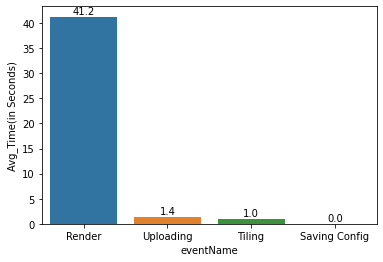


2. **which taskid takes more runtime?**

The task which take more run time need to be identified for a better business perspective and could make a more change in developing a new system. From this data file it is identified that there are 65793 task id's and for analysis it is taken as top 10 task id's using the below code.

```
toptask=data1_2.groupby(['taskId','x','y'], as_index=False)['TotalTime(in Seconds)'].sum()
toptask=toptask.sort_values(['TotalTime(in Seconds)'], ascending=False).head(10)
toptask
```

|taskId|	x	|y|	TotalTime(in Seconds)|
|-------|:-----|:-----|:-----|
|ef15022d-f816-4434-b41e-709cb996bc08|	3	|7	|94.695|
|76fb8e93-c3a6-456c-9661-3b7407800027	|70	|6	|90.351|
|33805	83064f91-5a19-4526-8673-38ab28dd3ab7	|14	|1	|89.292|
|43629	a95d501e-d5d5-4fb4-9119-98120bf6f4d5	|91	|105	|83.498|
|9602	25b410b5-f5ef-4a2f-8b21-29175bca35fc	|92	|106|	82.388|
|53962	d194b27d-d421-47d3-ae41-eed07a00e8d4	|92	|107|	79.752|
|62904	f4a61a45-2e92-4aa0-9219-4425ce0ec17e	|93	|107|	77.479|
|38388	94bfb9b3-80c2-44e7-8869-c29a0007bbe0	|93	|108|	75.919|
|53582	d01f0571-c929-4bb8-9692-5ef053c1da1d	|92	|104|	75.763|
|20813	51271d84-a39c-4a33-93c0-eda4648ad5bf	|95	|106|	75.555|
|
|

```
sns.scatterplot(data=toptask, x="x", y="y", hue="TotalTime(in Seconds)", size="TotalTime(in Seconds)",sizes=(10, 400), legend="full")
```

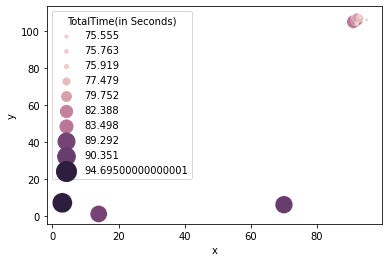

3. **which hostnames consume more power?**



